In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from itertools import product
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [2]:
class GameTheoreticCommunityDetection:
    """
    Community detection using game theory principles, where nodes act as 
    agents maximizing their utility by joining the optimal community.
    """
    
    def __init__(self, G, internal_weight=1.0, external_penalty=2.0, size_penalty=0.1, max_iterations=100):
        """
        Initialize the game-theoretic community detector.
        
        Parameters:
            G (nx.Graph): Undirected graph with optional edge weights
            internal_weight (float): Weight for internal connectivity reward
            external_penalty (float): Weight for external connectivity penalty
            size_penalty (float): Penalty for large community sizes
            max_iterations (int): Maximum number of iterations
        """
        self.G = G
        self.internal_weight = internal_weight
        self.external_penalty = external_penalty
        self.size_penalty = size_penalty
        self.max_iterations = max_iterations
        self.partition = None
        self.next_label = 0
        
    def initialize_partition(self, method="singleton"):
        """
        Initialize communities using different strategies.
        
        Parameters:
            method (str): Initialization method ('random', 'singleton')
        
        Returns:
            dict: Node to community mapping
        """
        nodes = list(self.G.nodes())
        
        if method == "random":
            k = max(2, int(np.sqrt(len(nodes))))
            partition = {node: random.randint(0, k-1) for node in nodes}
        
        elif method == "singleton":
            partition = {node: i for i, node in enumerate(nodes)}
        
        else:
            raise ValueError(f"Unknown initialization method: {method}")
        
        self.next_label = max(partition.values()) + 1 if partition else 0
        return partition
    
    def calculate_node_utility(self, node, community, partition):
        """
        Calculate utility for a node in a specific community, using edge weights.
        
        Parameters:
            node: The node to evaluate
            community: Target community ID
            partition: Current node->community mapping
            
        Returns:
            float: Utility score
        """
        internal_edge_weights = 0
        external_edge_weights = 0
        
        for neighbor in self.G.neighbors(node):
            weight = self.G[node][neighbor].get('weight', 1.0)
            if partition.get(neighbor) == community:
                internal_edge_weights += weight
            else:
                external_edge_weights += weight
        
        comm_size = sum(1 for n, c in partition.items() if c == community and n != node)
        utility = (self.internal_weight * internal_edge_weights - 
                  self.external_penalty * external_edge_weights - 
                  self.size_penalty * comm_size)
        return utility
    
    def find_best_community(self, node, partition):
        """
        Find the community that maximizes a node's utility, including option to form a singleton.
        
        Parameters:
            node: Node to evaluate
            partition: Current partition
            
        Returns:
            tuple: (best community ID or 'new', utility)
        """
        current_community = partition.get(node)
        current_utility = self.calculate_node_utility(node, current_community, partition)
        best_utility = current_utility
        best_community = current_community
        
        candidate_communities = set()
        for neighbor in self.G.neighbors(node):
            if neighbor in partition:
                candidate_communities.add(partition[neighbor])
        
        for comm in candidate_communities:
            if comm != current_community:
                utility = self.calculate_node_utility(node, comm, partition)
                if utility > best_utility:
                    best_utility = utility
                    best_community = comm
        
        singleton_utility = -self.external_penalty * sum(
            self.G[node][neighbor].get('weight', 1.0) for neighbor in self.G.neighbors(node)
        )
        if singleton_utility > best_utility:
            best_utility = singleton_utility
            best_community = "new"
        
        return best_community, best_utility
    
    def force_split(self, partition):
        """
        If only one community exists, split it into two based on highest degree node and its neighbors.
        
        Parameters:
            partition: Current node->community mapping
            
        Returns:
            dict: Updated partition
        """
        communities = set(partition.values())
        if len(communities) > 1:
            return partition
        
        degrees = self.G.degree(weight='weight')
        max_degree_node = max(degrees, key=lambda x: x[1])[0]
        
        new_partition = partition.copy()
        new_label = self.next_label
        self.next_label += 1
        
        new_partition[max_degree_node] = new_label
        for neighbor in self.G.neighbors(max_degree_node):
            new_partition[neighbor] = new_label
        
        return new_partition
    
    def merge_small_communities(self, partition, min_size=3):
        """
        Merge communities smaller than min_size into the best neighboring community.
        
        Parameters:
            partition: Current node->community mapping
            min_size: Minimum allowed community size
            
        Returns:
            dict: Updated partition
        """
        communities = defaultdict(list)
        for node, comm_id in partition.items():
            communities[comm_id].append(node)
        
        new_partition = partition.copy()
        for comm_id, nodes in communities.items():
            if len(nodes) < min_size:
                best_comm = None
                best_utility = float('-inf')
                
                neighbor_comms = set()
                for node in nodes:
                    for neighbor in self.G.neighbors(node):
                        if neighbor in partition and partition[neighbor] != comm_id:
                            neighbor_comms.add(partition[neighbor])
                
                for target_comm in neighbor_comms:
                    total_utility = 0
                    for node in nodes:
                        total_utility += self.calculate_node_utility(node, target_comm, partition)
                    if total_utility > best_utility:
                        best_utility = total_utility
                        best_comm = target_comm
                
                if best_comm is not None:
                    for node in nodes:
                        new_partition[node] = best_comm
        
        return new_partition
    
    def run(self, init_method="singleton"):
        """
        Execute the game-theoretic community detection algorithm.
        
        Parameters:
            init_method (str): Method to initialize communities
            
        Returns:
            dict: Final node to community mapping
        """
        partition = self.initialize_partition(method=init_method)
        
        iteration = 0
        changes = True
        
        while changes and iteration < self.max_iterations:
            changes = False
            nodes = list(self.G.nodes())
            random.shuffle(nodes)
            
            for node in nodes:
                best_community, _ = self.find_best_community(node, partition)
                current_community = partition.get(node)
                
                if best_community != current_community:
                    if best_community == "new":
                        partition[node] = self.next_label
                        self.next_label += 1
                    else:
                        partition[node] = best_community
                    changes = True
            
            partition = self.force_split(partition)
            partition = self.merge_small_communities(partition, min_size=3)
            
            iteration += 1
            # print(f"Iteration {iteration}: {self.count_communities(partition)} communities")
        
        self.partition = self.renumber_communities(partition)
        return self.partition
    
    @staticmethod
    def count_communities(partition):
        """Count number of distinct communities in partition."""
        return len(set(partition.values()))
    
    @staticmethod
    def renumber_communities(partition):
        """Renumber community IDs to be consecutive integers starting from 0."""
        communities = defaultdict(list)
        for node, comm in partition.items():
            communities[comm].append(node)
        
        new_partition = {}
        for new_id, (_, nodes) in enumerate(communities.items()):
            for node in nodes:
                new_partition[node] = new_id
        return new_partition
    
    def calculate_modularity(self):
        """Calculate modularity of the current partition."""
        if self.partition is None:
            return None
        communities = defaultdict(list)
        for node, comm_id in self.partition.items():
            communities[comm_id].append(node)
        return nx.community.modularity(self.G, communities.values(), weight='weight')
    
    def calculate_community_metrics(self, ground_truth=None):
        """
        Calculate various metrics for the detected communities.
        
        Parameters:
            ground_truth (dict): Optional node to ground truth community mapping
            
        Returns:
            dict: Metrics including modularity, NMI, ARI, etc.
        """
        if self.partition is None:
            return None
        
        communities = defaultdict(list)
        for node, comm_id in self.partition.items():
            communities[comm_id].append(node)
        
        metrics = {
            'modularity': nx.community.modularity(self.G, communities.values(), weight='weight'),
            'num_communities': len(communities),
            'sizes': [len(nodes) for nodes in communities.values()],
            'internal_densities': [],
            'external_densities': [],
            'communities': communities
        }
        
        if ground_truth:
            true_labels = [ground_truth[node] for node in self.G.nodes()]
            detected_labels = [self.partition[node] for node in self.G.nodes()]
            metrics['nmi'] = normalized_mutual_info_score(true_labels, detected_labels)
            metrics['ari'] = adjusted_rand_score(true_labels, detected_labels)
        
        for comm_id, nodes in communities.items():
            subgraph = self.G.subgraph(nodes)
            potential_edges = len(nodes) * (len(nodes) - 1) / 2
            internal_edges = sum(subgraph[u][v].get('weight', 1.0) for u, v in subgraph.edges()) / 2
            internal_density = internal_edges / potential_edges if potential_edges > 0 else 0
            metrics['internal_densities'].append(internal_density)
            
            external_edges = 0
            for node in nodes:
                external_edges += sum(
                    self.G[node][neighbor].get('weight', 1.0) 
                    for neighbor in self.G.neighbors(node) 
                    if self.partition.get(neighbor) != comm_id
                )
            other_nodes = len(self.G.nodes()) - len(nodes)
            potential_external = len(nodes) * other_nodes
            external_density = external_edges / potential_external if potential_external > 0 else 0
            metrics['external_densities'].append(external_density)
        
        return metrics
        
    def visualize(self, with_labels=True, figsize=(12, 8), node_labels=None, ground_truth=None):
        """
        Visualize the graph with communities colored differently, optionally showing ground truth.
        
        Parameters:
            with_labels (bool): Whether to show node labels
            figsize (tuple): Figure size
            node_labels (dict): Optional mapping of node_id -> label
            ground_truth (dict): Optional ground truth partition for comparison
        """
        if self.partition is None:
            raise ValueError("Run the algorithm first")
        
        fig, ax = plt.subplots(1, 2 if ground_truth else 1, figsize=(figsize[0] * (2 if ground_truth else 1), figsize[1]))
        if not ground_truth:
            ax = [ax]
        
        pos = nx.spring_layout(self.G, seed=42)
        
        communities = set(self.partition.values())
        colors = plt.cm.rainbow(np.linspace(0, 1, max(len(communities), 3)))
        
        for i, comm_id in enumerate(communities):
            nodes = [node for node, comm in self.partition.items() if comm == comm_id]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=[colors[i]],
                                  node_size=300, alpha=0.8, label=f"Community {comm_id}", ax=ax[0])
        
        nx.draw_networkx_edges(self.G, pos, alpha=0.5, ax=ax[0])
        if with_labels:
            nx.draw_networkx_labels(self.G, pos, labels=node_labels, font_size=10, ax=ax[0])
        
        ax[0].set_title("Detected Communities")
        ax[0].legend(loc="upper right")
        ax[0].axis('off')
        
        if ground_truth:
            communities = set(ground_truth.values())
            for i, comm_id in enumerate(communities):
                nodes = [node for node, comm in ground_truth.items() if comm == comm_id]
                nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=[colors[i]],
                                      node_size=300, alpha=0.8, label=f"True Community {comm_id}", ax=ax[1])
            
            nx.draw_networkx_edges(self.G, pos, alpha=0.5, ax=ax[1])
            if with_labels:
                nx.draw_networkx_labels(self.G, pos, labels=node_labels, font_size=10, ax=ax[1])
            
            ax[1].set_title("Ground Truth Communities")
            ax[1].legend(loc="upper right")
            ax[1].axis('off')
        
        plt.tight_layout()
        return plt

Running grid search...

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.05
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.1
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.15
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.2
Average ARI: 0.6841, NMI: 0.6912, Modularity: 0.4345
Average number of communities: 3, Example sizes: [11, 5, 18]

Testing: internal_weight=0.3, external_penalty=1.5, size_penalty=0.05
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 18]

Testing: internal_weight=0.3, external_penal

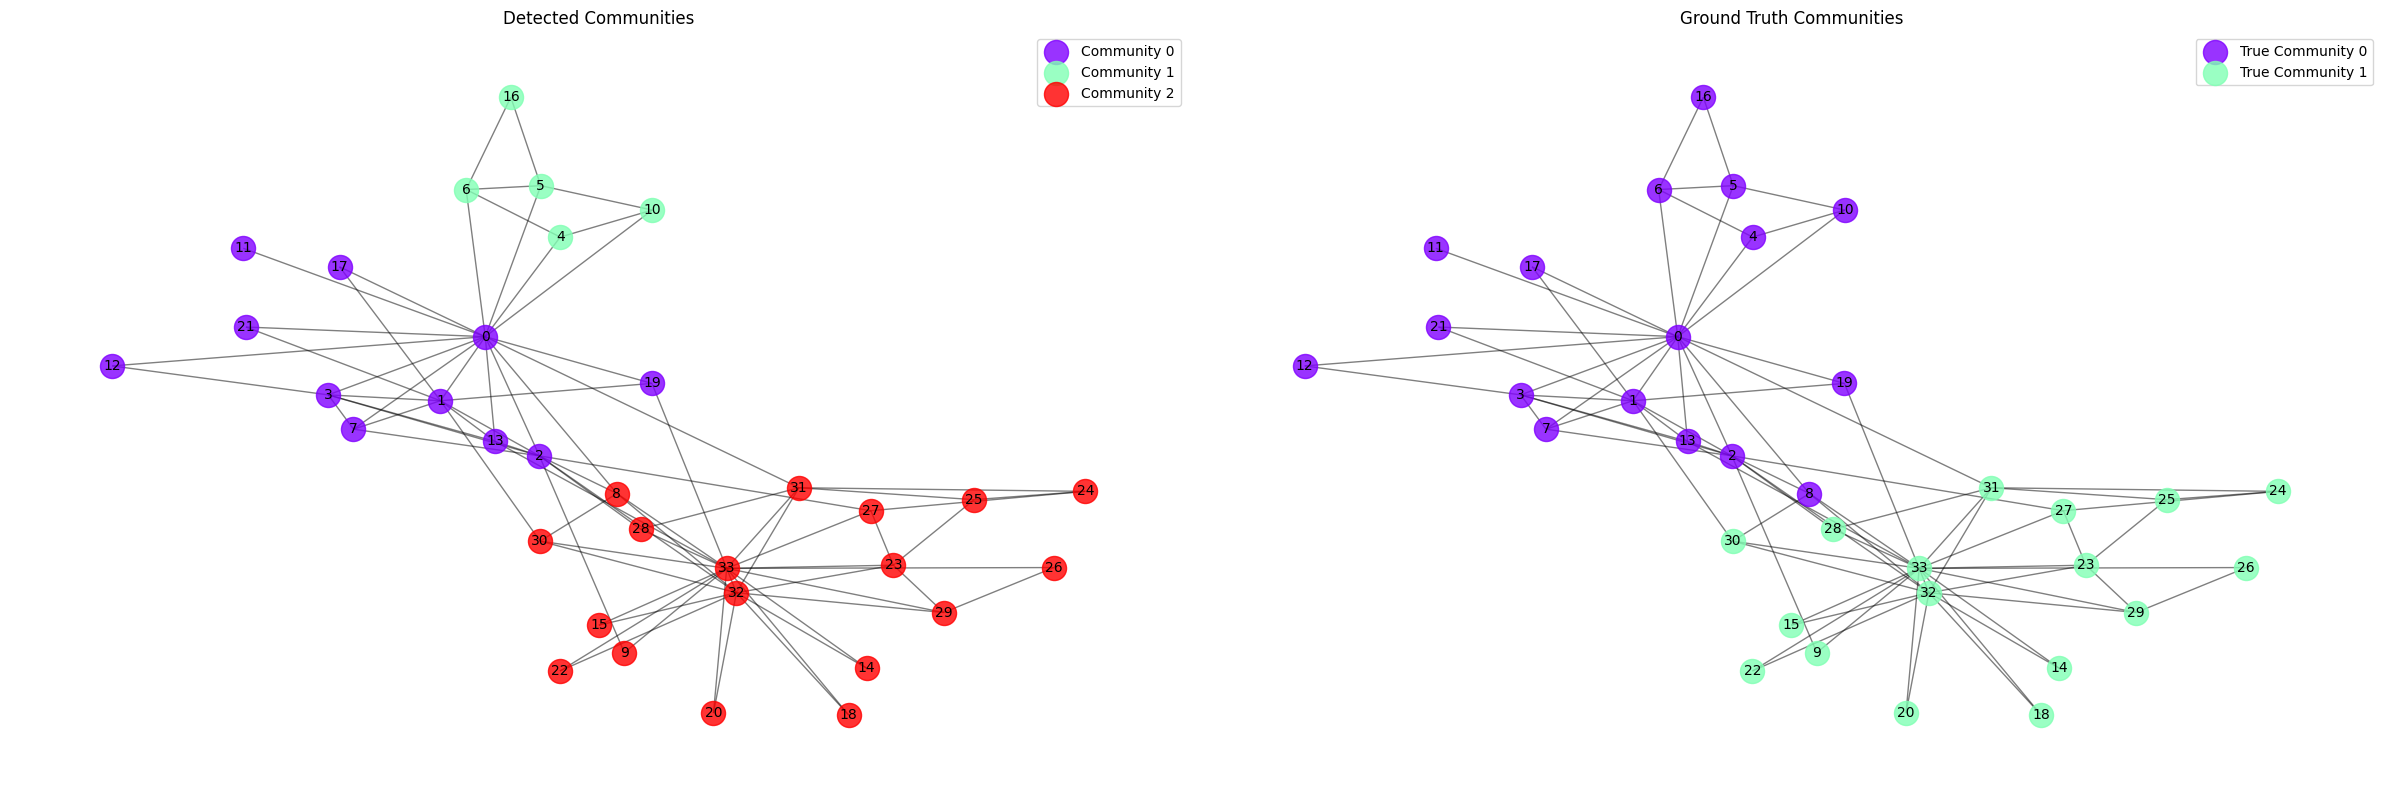

In [3]:
# Load the benchmark graph
G = nx.karate_club_graph()

# Ground truth
true_partition = {node: 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in G.nodes()}

# Define expanded parameter grid
param_grid = {
    'internal_weight': [0.3, 0.5, 0.7],
    'external_penalty': [1.0, 1.5, 2.0],
    'size_penalty': [0.05, 0.1, 0.15, 0.2]
}

best_ari = -1
best_params = None
best_metrics = None
best_detector = None

# Number of runs per parameter set to account for randomness
num_runs = 3

# Grid search
print("Running grid search...")
for internal_weight, external_penalty, size_penalty in product(
    param_grid['internal_weight'], param_grid['external_penalty'], param_grid['size_penalty']
):
    print(f"\nTesting: internal_weight={internal_weight}, external_penalty={external_penalty}, size_penalty={size_penalty}")
    ari_scores = []
    metrics_list = []
    
    for run in range(num_runs):
        detector = GameTheoreticCommunityDetection(
            G, internal_weight=internal_weight, external_penalty=external_penalty, size_penalty=size_penalty
        )
        partition = detector.run(init_method="singleton")
        metrics = detector.calculate_community_metrics(ground_truth=true_partition)
        ari_scores.append(metrics['ari'])
        metrics_list.append(metrics)
    
    # Average metrics over runs
    avg_ari = np.mean(ari_scores)
    avg_metrics = {
        'ari': avg_ari,
        'nmi': np.mean([m['nmi'] for m in metrics_list]),
        'modularity': np.mean([m['modularity'] for m in metrics_list]),
        'num_communities': int(np.mean([m['num_communities'] for m in metrics_list])),
        'sizes': metrics_list[0]['sizes'],  # Take sizes from last run (may vary slightly)
        'internal_densities': np.mean([np.mean(m['internal_densities']) for m in metrics_list]),
        'external_densities': np.mean([np.mean(m['external_densities']) for m in metrics_list])
    }
    
    print(f"Average ARI: {avg_ari:.4f}, NMI: {avg_metrics['nmi']:.4f}, Modularity: {avg_metrics['modularity']:.4f}")
    print(f"Average number of communities: {avg_metrics['num_communities']}, Example sizes: {avg_metrics['sizes']}")
    
    if avg_ari > best_ari:
        best_ari = avg_ari
        best_params = {
            'internal_weight': internal_weight,
            'external_penalty': external_penalty,
            'size_penalty': size_penalty
        }
        best_metrics = avg_metrics
        best_detector = detector  # Save the last detector for visualization

# Report best results
print("\nBest Parameters:")
print(f"internal_weight: {best_params['internal_weight']}")
print(f"external_penalty: {best_params['external_penalty']}")
print(f"size_penalty: {best_params['size_penalty']}")
print("\nBest Metrics (Averaged):")
print(f"Number of communities: {best_metrics['num_communities']}")
print(f"Example community sizes: {best_metrics['sizes']}")
print(f"Modularity: {best_metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {best_metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {best_metrics['ari']:.4f}")
print(f"Average internal density: {best_metrics['internal_densities']:.4f}")
print(f"Average external density: {best_metrics['external_densities']:.4f}")

# Visualize the best result
plt = best_detector.visualize(ground_truth=true_partition)


Community Metrics:
Number of communities: 3
Community sizes: [11, 5, 18]
Communities: [[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [4, 5, 6, 10, 16], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Modularity: 0.4345
Normalized Mutual Information (NMI): 0.6912
Adjusted Rand Index (ARI): 0.6841
Average internal density: 0.6456
Average external density: 0.0942


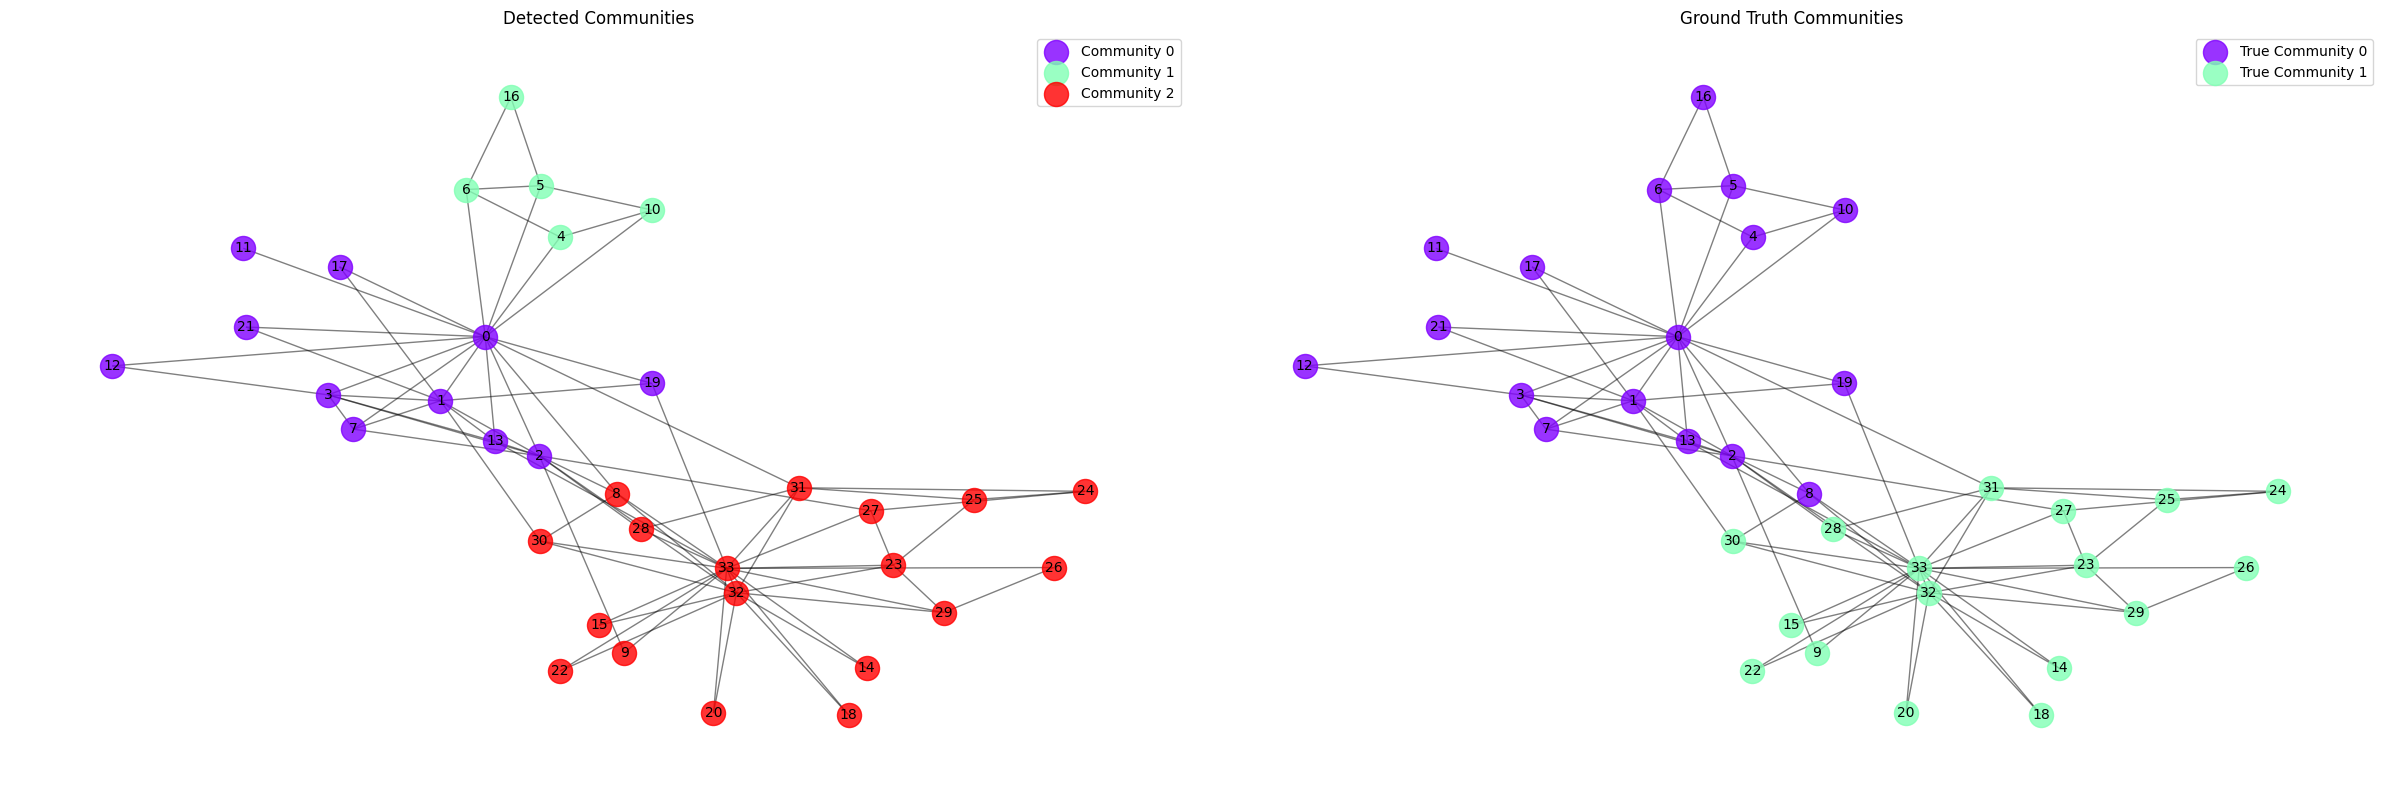

In [4]:
# Load the benchmark graph
G = nx.karate_club_graph()

# Ground truth
true_partition = {node: 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in G.nodes()}

detector = GameTheoreticCommunityDetection(G)
partition = detector.run(init_method="singleton")
metrics = detector.calculate_community_metrics(ground_truth=true_partition)

print("\nCommunity Metrics:")
print(f"Number of communities: {metrics['num_communities']}")
print(f"Community sizes: {metrics['sizes']}")
print(f"Communities: {[sorted(metrics['communities'][i]) for i in range(metrics['num_communities'])]}")
print(f"Modularity: {metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Average internal density: {np.mean(metrics['internal_densities']):.4f}")
print(f"Average external density: {np.mean(metrics['external_densities']):.4f}")

# Visualize the results
plt = detector.visualize(ground_truth=true_partition)

In [5]:
G.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

In [7]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3}), (0, 4, {'weight': 3}), (0, 5, {'weight': 3}), (0, 6, {'weight': 3}), (0, 7, {'weight': 2}), (0, 8, {'weight': 2}), (0, 10, {'weight': 2}), (0, 11, {'weight': 3}), (0, 12, {'weight': 1}), (0, 13, {'weight': 3}), (0, 17, {'weight': 2}), (0, 19, {'weight': 2}), (0, 21, {'weight': 2}), (0, 31, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 3}), (1, 7, {'weight': 4}), (1, 13, {'weight': 5}), (1, 17, {'weight': 1}), (1, 19, {'weight': 2}), (1, 21, {'weight': 2}), (1, 30, {'weight': 2}), (2, 3, {'weight': 3}), (2, 7, {'weight': 4}), (2, 8, {'weight': 5}), (2, 9, {'weight': 1}), (2, 13, {'weight': 3}), (2, 27, {'weight': 2}), (2, 28, {'weight': 2}), (2, 32, {'weight': 2}), (3, 7, {'weight': 3}), (3, 12, {'weight': 3}), (3, 13, {'weight': 3}), (4, 6, {'weight': 2}), (4, 10, {'weight': 3}), (5, 6, {'weight': 5}), (5, 10, {'weight': 3}), (5, 16, {'weight': 3}), (6, 16, {'weight': 3}), (8, 30, {'weight': 3


Community Metrics:
Number of communities: 3
Community sizes: [4, 4, 4]
Communities: [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
Modularity: 0.6000
Normalized Mutual Information (NMI): 1.0000
Adjusted Rand Index (ARI): 1.0000
Average internal density: 1.1667
Average external density: 0.0625


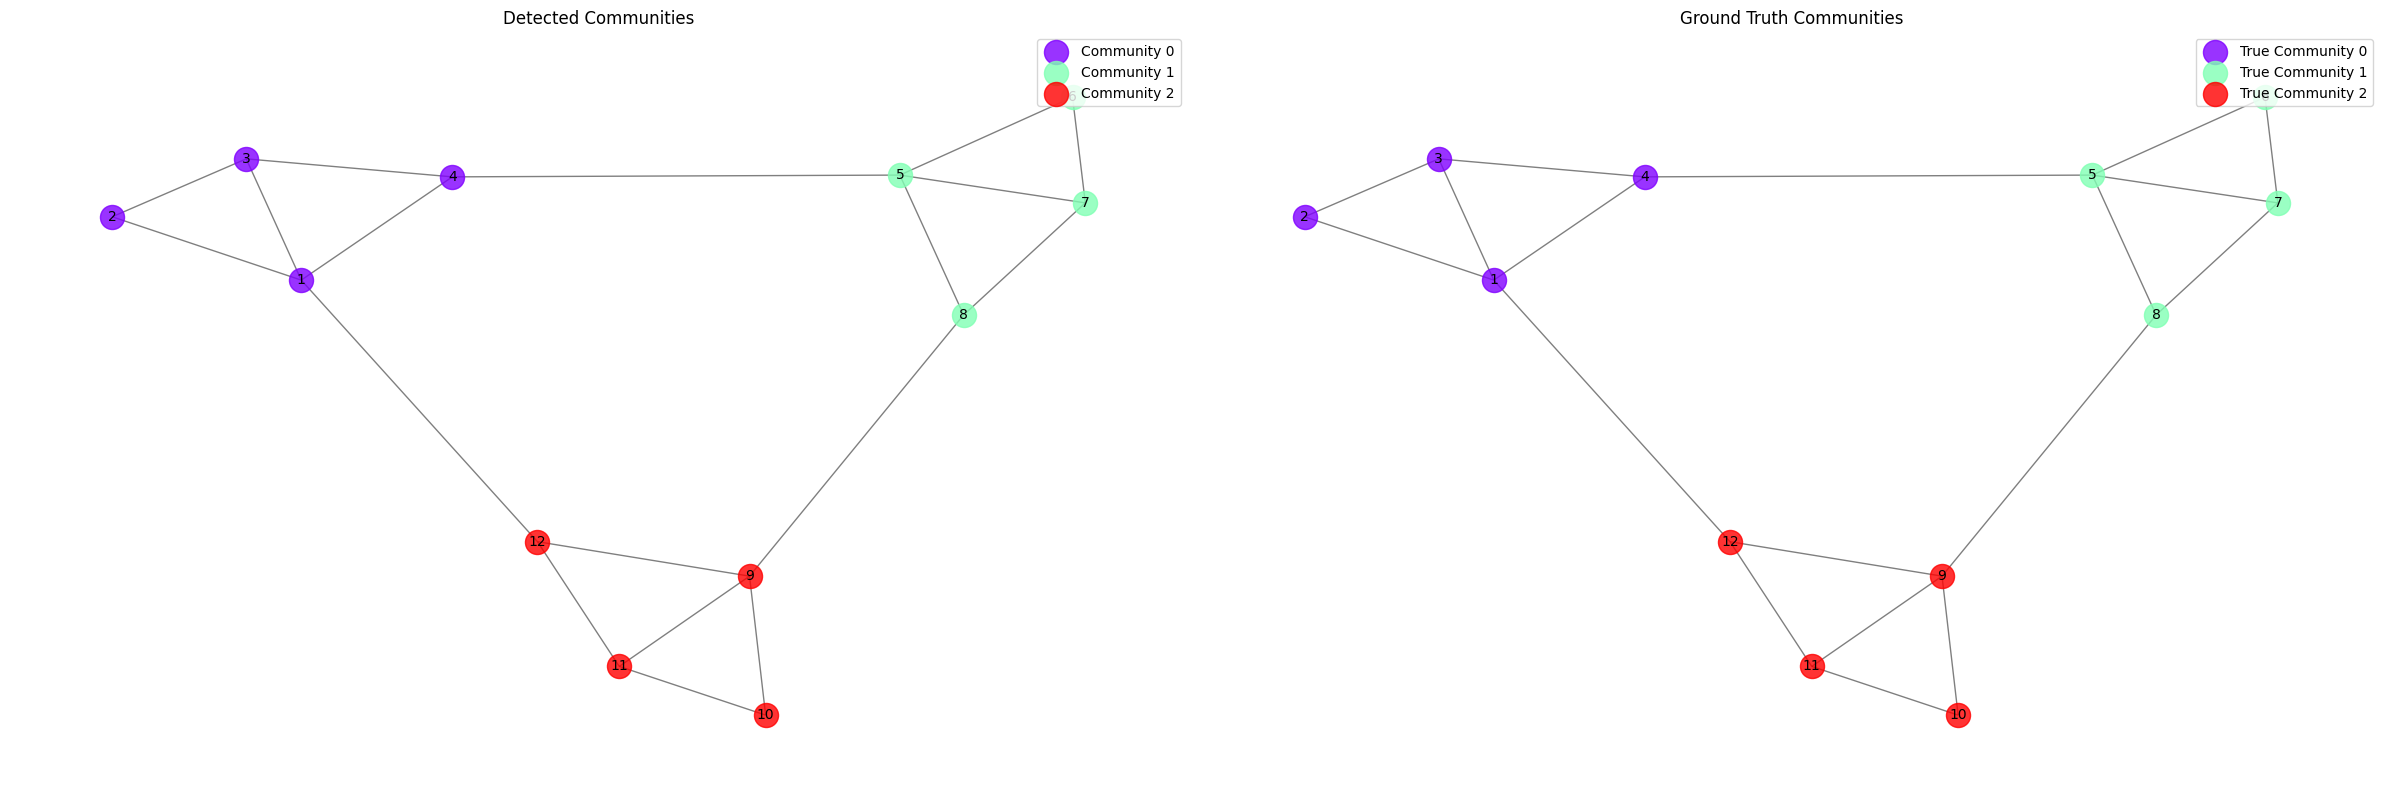

In [6]:
# Create the graph
G_undirected = nx.Graph()
nodes = list(range(1, 13))
G_undirected.add_nodes_from(nodes)

# Cluster A: nodes 1-4
edges_clusterA = [(1,2,3), (2,3,3), (3,4,3), (4,1,3), (1,3,2)]
# Cluster B: nodes 5-8
edges_clusterB = [(5,6,3), (6,7,3), (7,8,3), (8,5,3), (5,7,2)]
# Cluster C: nodes 9-12
edges_clusterC = [(9,10,3), (10,11,3), (11,12,3), (12,9,3), (9,11,2)]
# Inter-cluster edges
inter_edges = [(4,5,1), (8,9,1), (12,1,1)]

for u, v, w in edges_clusterA + edges_clusterB + edges_clusterC + inter_edges:
    G_undirected.add_edge(u, v, weight=w)

# Ground truth for validation
ground_truth = {
    **{i: 0 for i in range(1, 5)},  # Cluster A: nodes 1-4
    **{i: 1 for i in range(5, 9)},  # Cluster B: nodes 5-8
    **{i: 2 for i in range(9, 13)}  # Cluster C: nodes 9-12
}

detector = GameTheoreticCommunityDetection(G_undirected)
partition = detector.run(init_method="singleton")

# Calculate metrics
metrics = detector.calculate_community_metrics(ground_truth=ground_truth)
print("\nCommunity Metrics:")
print(f"Number of communities: {metrics['num_communities']}")
print(f"Community sizes: {metrics['sizes']}")
print(f"Communities: {[sorted(metrics['communities'][i]) for i in range(metrics['num_communities'])]}")
print(f"Modularity: {metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Average internal density: {np.mean(metrics['internal_densities']):.4f}")
print(f"Average external density: {np.mean(metrics['external_densities']):.4f}")

# Visualize the results
plt = detector.visualize(ground_truth=ground_truth)